# IMDB Sentiment Analysis - Pretrained

## 1.0 Overview

- **Problem**: sentiment analysis, binary classification.
- **Source of data**: [raw IMDB dataset](http://mng.bz/0tIo).
- **Source of GloVe word embeddings**: [Stanford GloVe - glove.6B.zip](https://nlp.stanford.edu/projects/glove)

## 2.0 Preprocessing

### 2.1 Processing the labels of raw IMDB data

In [3]:
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### 2.2 Tokenizing the text of the raw IMDB data

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100                      # Cut reviews after 100 words
training_samples = 200           # Train on 200 examples
validation_samples = 10000        # Validate on 10000 samples
max_words = 10000                 # Consider only top 10000 words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index # Word dictionary
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Shuffle the data before train_test_split
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### 2.3 Preprocessing the embeddings

In [10]:
glove_dir = './glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### 2.4 Preparing the GloVe word-embedding matrix

Build this embedding matrix to later load into an `Embedding` layer. The matrix has shape `(max_words, embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index $i$ in the reference word index (built during tokenization). As a remark, index 0 is a placeholder and does not stand for any word or token.

In [15]:
# Take a peek at word_index
for word, i in word_index.items():
    print(word, i)
    if i > 10:
        break

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

the 1
and 2
a 3
of 4
to 5
is 6
br 7
in 8
it 9
i 10
this 11


## 3.0 Model with pretrained embedding

### 3.1 Model definition

In [18]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 3.2 Load the GloVe embeddings and freeze it

In [19]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### 3.3 Train the model

In [20]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val)
)

model.save_weights('pretrained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 1.6227 - acc: 0.4650 - val_loss: 0.7178 - val_acc: 0.4984
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5403 - acc: 0.7900 - val_loss: 0.8451 - val_acc: 0.4960
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4560 - acc: 0.7500 - val_loss: 1.0206 - val_acc: 0.4964
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4630 - acc: 0.7350 - val_loss: 0.7099 - val_acc: 0.5043
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3124 - acc: 0.9350 - val_loss: 0.7414 - val_acc: 0.4984
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2477 - acc: 0.9300 - val_loss: 1.1357 - val_acc: 0.4956
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1984 - acc: 0.9450 - val_loss: 0.9314 - val_acc: 0.4947
Epoch 8/10
200/200 [========

### 3.4 Plot the history

<Figure size 432x288 with 0 Axes>

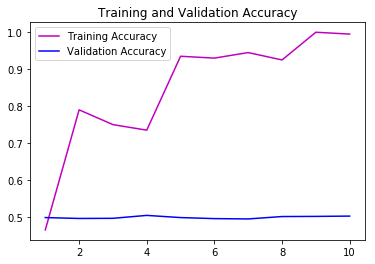

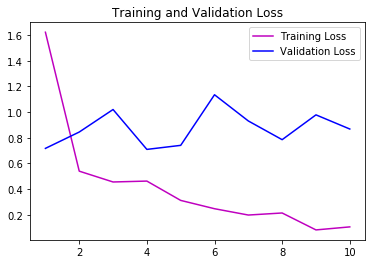

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

# history = history.history
acc, val_acc, loss, val_loss = history['acc'], history['val_acc'], history['loss'], history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'm', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'm', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## 4.0 Model without pretrained embedding

### 4.1 Model definition

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 3.2 Train the model

In [27]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val)
)

model.save_weights('from_scratch.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.8306 - val_acc: 0.5004
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 1.7781e-04 - acc: 1.0000 - val_loss: 0.8753 - val_acc: 0.5008
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 9.7320e-05 - acc: 1.0000 - val_loss: 0.8631 - val_acc: 0.5020
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 5.4428e-05 - acc: 1.0000 - val_loss: 0.8703 - val_acc: 0.5009
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 3.6784e-05 - acc: 1.0000 - val_loss: 0.8769 - val_acc: 0.5005
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 2.5362e-05 - acc: 1.0000 - val_loss: 0.8851 - val_acc: 0.5009
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 1.7570e-05 - acc: 1.0000 - val_loss: 0.8951 - val_acc: 0.4983
Epoc

### 4.3 Plot the history

<Figure size 432x288 with 0 Axes>

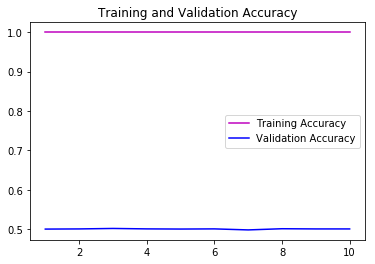

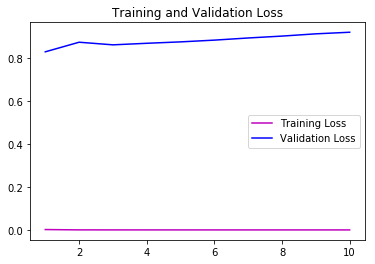

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt

history = history.history
acc, val_acc, loss, val_loss = history['acc'], history['val_acc'], history['loss'], history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'm', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'm', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

### 4.4 Evaluate with test set

In [31]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [32]:
model.load_weights('pretrained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 74us/step


[0.8893256636428833, 0.49196]

In [33]:
model.load_weights('from_scratch.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 65us/step


[0.9000148493957519, 0.50916]